In [67]:
#pip install pandas_datareader

In [68]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_datareader.data as web
from datetime import datetime, timedelta

import os
import glob

In [69]:
today     = datetime.today().date()
end_date  = today - timedelta(days=1)
start_date = "2010-01-01"

In [70]:
dates = pd.date_range(start=start_date, end=end_date)
Main_df = pd.DataFrame({"date": dates})

# optional: make 'date' a plain python date (instead of Timestamp)
Main_df["date"] = Main_df["date"].dt.date
Main_df.set_index("date", inplace=True)

print(Main_df.head())
print(Main_df.tail())

Empty DataFrame
Columns: []
Index: [2010-01-01, 2010-01-02, 2010-01-03, 2010-01-04, 2010-01-05]
Empty DataFrame
Columns: []
Index: [2025-07-18, 2025-07-19, 2025-07-20, 2025-07-21, 2025-07-22]


# BTC

In [71]:
# 1) Point to your folder
data_path = "../Data/BTC"  

# 2) Find all files matching btc_2010.csv ... btc_2025.csv
all_files = glob.glob(os.path.join(data_path, "btc_*.csv"))

# 3) Read and collect
df_list = []
for filepath in all_files:
    # adjust parse_dates/index_col to whatever your CSV uses
    year_df = pd.read_csv(
        filepath,
        parse_dates=["timestamp"],    # or the name of your date column
        sep=";"
    )

    df_list.append(year_df)

# 4) Concatenate and sort by date
bitcoin_df = pd.concat(df_list).sort_index()

# 5) (Optional) Reset index if you want Date as a column:
# bitcoin_df = bitcoin_df.reset_index()

bitcoin_df["Date"] = pd.to_datetime(bitcoin_df["timestamp"]).dt.date
bitcoin_df=bitcoin_df.set_index("Date")
bitcoin_df=bitcoin_df.sort_index(ascending=True)

#bitcoin_df=bitcoin_df.drop(columns=["timeOpen", "timeClose", "timeHigh", "timeLow", 'name', 'timestamp'])



bitcoin_df=bitcoin_df[['close','volume','marketCap']]
bitcoin_df=bitcoin_df.rename(columns={"close": "BTC", "volume": "BTC_Volume"})
bitcoin_df['BTC_count']=bitcoin_df['marketCap']/bitcoin_df['BTC']
bitcoin_df.drop(columns=['marketCap'], inplace=True)
print(bitcoin_df.head())      # first few rows
print(bitcoin_df.tail())

                 BTC  BTC_Volume     BTC_count
Date                                          
2010-07-14  0.056402      261.54  3.373269e+06
2010-07-15  0.057568      445.80  3.404354e+06
2010-07-16  0.066492      497.25  3.429713e+06
2010-07-17  0.065993       19.99  3.438340e+06
2010-07-18  0.078814       75.13  3.446975e+06
                      BTC    BTC_Volume     BTC_count
Date                                                 
2025-07-17  119289.842192  7.236384e+10  1.989281e+07
2025-07-18  118003.224496  7.794580e+10  1.989334e+07
2025-07-19  117939.978739  4.756456e+10  1.989535e+07
2025-07-20  117300.785740  5.751545e+10  1.989606e+07
2025-07-21  117439.535800  6.982009e+10  1.989339e+07


            BTC  BTC_Volume  BTC_count
2010-01-01  NaN         NaN        NaN
2010-01-02  NaN         NaN        NaN
2010-01-03  NaN         NaN        NaN
2010-01-04  NaN         NaN        NaN
2010-01-05  NaN         NaN        NaN
                      BTC    BTC_Volume     BTC_count
2025-07-18  118003.224496  7.794580e+10  1.989334e+07
2025-07-19  117939.978739  4.756456e+10  1.989535e+07
2025-07-20  117300.785740  5.751545e+10  1.989606e+07
2025-07-21  117439.535800  6.982009e+10  1.989339e+07
2025-07-22            NaN           NaN           NaN


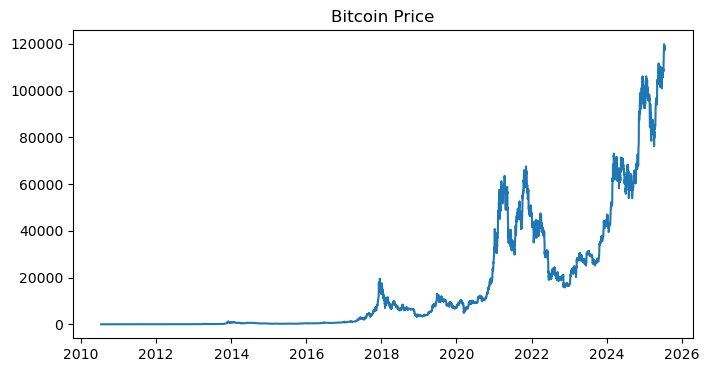

In [72]:
Main_df = Main_df.join(bitcoin_df, how="left")

print(Main_df.head())
print(Main_df.tail())
Main_df["BTC"].plot(figsize=(8, 4), title="Bitcoin Price")
plt.show()

In [73]:
# Ensure Main_df exists and index is DatetimeIndex
Main_df.index = pd.to_datetime(Main_df.index)
Main_df = Main_df.sort_index()

# 1) Halving dates and rewards
halving_dates = [
    pd.Timestamp('2012-11-28'),
    pd.Timestamp('2016-07-09'),
    pd.Timestamp('2020-05-11'),
    pd.Timestamp('2024-04-20')
]
rewards = [50, 25, 12.5, 6.25, 3.125]  # intervals: before 1st, 1st-2nd, etc.

# 2) Determine interval index for each date
idxs = np.searchsorted(halving_dates, Main_df.index, side='right')

# 3) Assign reward
Main_df['reward'] = [rewards[i] for i in idxs]

# 4) Compute last halving date for each row
last_halving = [halving_dates[i-1] if i > 0 else pd.NaT for i in idxs]
last_halving_series = pd.Series(last_halving, index=Main_df.index)

# 5) Days since last halving using .dt.days
delta = Main_df.index.to_series() - last_halving_series
Main_df['days_since_halving'] = delta.dt.days

Main_df.index=Main_df.index.date # convert index to date only
# 6) Inspect
Main_df.tail()


,BTC,BTC_Volume,BTC_count,reward,days_since_halving
2025-07-18,118003.224496,7.794580e+10,1.989334e+07,3.125,454.0
2025-07-19,117939.978739,4.756456e+10,1.989535e+07,3.125,455.0
2025-07-20,117300.785740,5.751545e+10,1.989606e+07,3.125,456.0
2025-07-21,117439.535800,6.982009e+10,1.989339e+07,3.125,457.0
2025-07-22,NaN,NaN,NaN,3.125,458.0


# Ethereum

In [74]:
# 1) Point to your folder
data_path = "../Data/ETH"  

# 2) Find all files matching btc_2010.csv ... btc_2025.csv
all_files = glob.glob(os.path.join(data_path, "eth_*.csv"))

# 3) Read and collect
df_list = []
for filepath in all_files:
    # adjust parse_dates/index_col to whatever your CSV uses
    year_df = pd.read_csv(
        filepath,
        parse_dates=["timestamp"],    # or the name of your date column
        sep=";"
    )

    df_list.append(year_df)

# 4) Concatenate and sort by date
eth_df = pd.concat(df_list).sort_index()

# 5) (Optional) Reset index if you want Date as a column:
# bitcoin_df = bitcoin_df.reset_index()

eth_df["Date"] = pd.to_datetime(eth_df["timestamp"]).dt.date
eth_df=eth_df.set_index("Date")
eth_df=eth_df.sort_index(ascending=True)

#bitcoin_df=bitcoin_df.drop(columns=["timeOpen", "timeClose", "timeHigh", "timeLow", 'name', 'timestamp'])



eth_df=eth_df[['close','volume','marketCap']]
eth_df=eth_df.rename(columns={"close": "ETH", "volume": "ETH_Volume"})
eth_df['ETH_count']=eth_df['marketCap']/eth_df['ETH']
eth_df.drop(columns=['marketCap'], inplace=True)
print(eth_df.head())      # first few rows
print(eth_df.tail())

                 ETH  ETH_Volume     ETH_count
Date                                          
2015-08-08  0.753325    674188.0  6.038150e+07
2015-08-09  0.701897    532170.0  6.040711e+07
2015-08-10  0.708448    405283.0  6.043967e+07
2015-08-11  1.067860   1463100.0  6.046606e+07
2015-08-12  1.217440   2150620.0  6.049170e+07
                    ETH    ETH_Volume     ETH_count
Date                                               
2025-07-17  3476.784398  4.753285e+10  1.206906e+08
2025-07-18  3549.016245  5.919847e+10  1.207105e+08
2025-07-19  3595.273669  2.603172e+10  1.207110e+08
2025-07-20  3759.471442  4.460045e+10  1.206943e+08
2025-07-21  3763.371253  4.261147e+10  1.206961e+08


            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  
2010-01-01         NaN        NaN  
2010-01-02         NaN        NaN  
2010-01-03         NaN        NaN  
2010-01-04         NaN        NaN  
2010-01-05         NaN        NaN  
                      BTC    BTC_Volume     BTC_count  reward  \
2025-07-18  118003.224496  7.794580e+10  1.989334e+07   3.125   
2025-07-19  117939.978739  4.756456e+10  1.989535e+07   3.125   
2025-07-20  117300.785740  5.751545e+10  1.989606e+07   3.125   
2025-07-21  117439.535800  6.982009e+10  1.989339e+07   3.125   
2025-07-

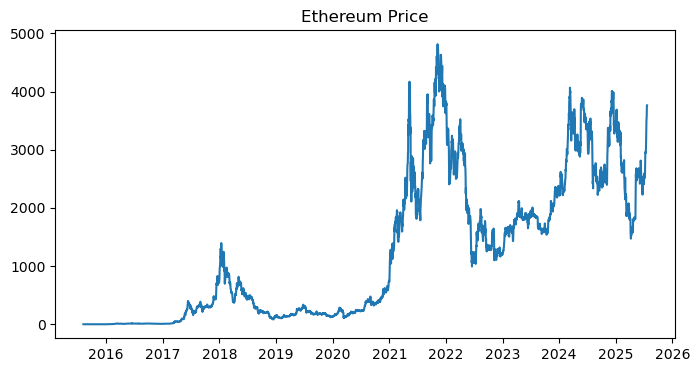

In [75]:
Main_df = Main_df.join(eth_df, how="left")

print(Main_df.head())
print(Main_df.tail())
Main_df["ETH"].plot(figsize=(8, 4), title="Ethereum Price")
plt.show()

# BCH

In [76]:
# 1) Point to your folder
data_path = "../Data/BCH"  

# 2) Find all files matching btc_2010.csv ... btc_2025.csv
all_files = glob.glob(os.path.join(data_path, "bch_*.csv"))

# 3) Read and collect
df_list = []
for filepath in all_files:
    # adjust parse_dates/index_col to whatever your CSV uses
    year_df = pd.read_csv(
        filepath,
        parse_dates=["timestamp"],    # or the name of your date column
        sep=";"
    )

    df_list.append(year_df)

# 4) Concatenate and sort by date
bch_df = pd.concat(df_list).sort_index()

# 5) (Optional) Reset index if you want Date as a column:
# bitcoin_df = bitcoin_df.reset_index()

bch_df["Date"] = pd.to_datetime(bch_df["timestamp"]).dt.date
bch_df=bch_df.set_index("Date")
bch_df=bch_df.sort_index(ascending=True)

#bitcoin_df=bitcoin_df.drop(columns=["timeOpen", "timeClose", "timeHigh", "timeLow", 'name', 'timestamp'])



bch_df=bch_df[['close','volume','marketCap']]
# print(bch_df.head())      # first few rows
# bch_df['marketCap'].plot(figsize=(8, 4), title="BCH Market Cap")
# plt.show()
bch_df=bch_df.rename(columns={"close": "BCH", "volume": "BCH_Volume"})
bch_df['BCH_count']=bch_df['marketCap']/bch_df['BCH']
bch_df.drop(columns=['marketCap'], inplace=True)
print(bch_df.head())      # first few rows
print(bch_df.tail())

                   BCH  BCH_Volume  BCH_count
Date                                         
2017-07-24  440.700989    190952.0        0.0
2017-07-25  406.897003    524908.0        0.0
2017-07-26  365.816010   1784640.0        0.0
2017-07-27  385.479004    533207.0        0.0
2017-07-28  406.045990   1230160.0        0.0
                   BCH    BCH_Volume     BCH_count
Date                                              
2025-07-17  500.064196  4.448698e+08  1.989843e+07
2025-07-18  514.428382  8.072254e+08  1.989972e+07
2025-07-19  513.423144  4.295625e+08  1.989957e+07
2025-07-20  547.876271  7.133608e+08  1.990013e+07
2025-07-21  523.554650  8.213232e+08  1.990053e+07


            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count  
2010-01-01         NaN        NaN  NaN         NaN        NaN  
2010-01-02         NaN        NaN  NaN         NaN        NaN  
2010-01-03         NaN        NaN  NaN         NaN        NaN  
2010-01-04         NaN        NaN  NaN         NaN        NaN  
2010-01-05         NaN        NaN  NaN         NaN        NaN  
                      BTC    BTC_Volume     BTC_count  reward  \
2025-07-18  118003.224496  7.794580e+10  1.989334e+07   3.125   
2025-07-19  117939.978739  4.756456

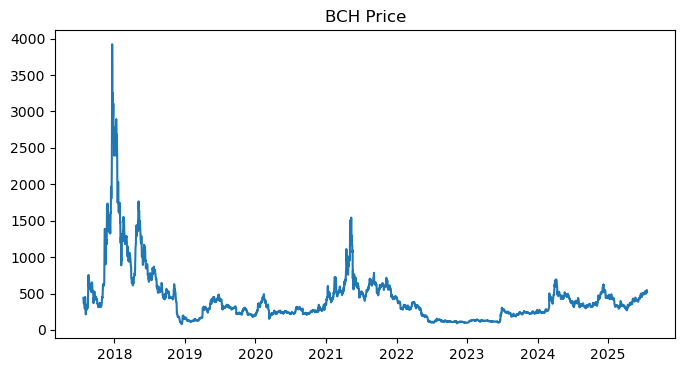

In [77]:
Main_df = Main_df.join(bch_df, how="left")

print(Main_df.head())
print(Main_df.tail())
Main_df["BCH"].plot(figsize=(8, 4), title="BCH Price")
plt.show()

# Dxy

In [78]:
data_path = "../Data/other/dxy.csv"
dxy_df=pd.read_csv(data_path)  
dxy_df.columns=['Date','DXY']
dxy_df["Date"] = pd.to_datetime(dxy_df["Date"]).dt.date
dxy_df.set_index("Date", inplace=True)
dxy_df.tail()

,DXY
Date,
2025-07-18,120.7674
2025-07-19,120.7674
2025-07-20,120.7674
2025-07-21,120.7674
2025-07-22,120.7674


In [79]:
Main_df=Main_df.join(dxy_df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN  
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN  
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN  
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566  
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236  
                      BTC    BTC_Volume     BTC_count  reward  \
2025-07-18  118003.224496  7.794580e+10  1.989

# Fed rate

In [80]:
data_path = "../Data/other/fed_rate.csv"
fed_df=pd.read_csv(data_path)  
fed_df.columns=['Date','fed_rate']
fed_df["Date"] = pd.to_datetime(fed_df["Date"]).dt.date
fed_df.set_index("Date", inplace=True)
fed_df.tail()

,fed_rate
Date,
2025-07-17,4.33
2025-07-18,4.33
2025-07-19,4.33
2025-07-20,4.33
2025-07-21,4.33


In [81]:
Main_df=Main_df.join(fed_df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate  
2010-01-01      0.05  
2010-01-02      0.05  
2010-01-03      0.05  
2010-01-04  

# Gold

In [82]:
data_path = "../Data/other/gold.csv"
gold_df=pd.read_csv(data_path)  
gold_df.columns=['Date','gold']
gold_df["Date"] = pd.to_datetime(gold_df["Date"]).dt.date
gold_df.set_index("Date", inplace=True)
gold_df.tail()

,gold
Date,
2025-07-18,308.390015
2025-07-19,308.390015
2025-07-20,308.390015
2025-07-21,313.130005
2025-07-22,313.130005


In [83]:
Main_df=Main_df.join(gold_df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate        gold  
2010-01-01      0.05         NaN  
2010-01-02      0.05         NaN  

# Inflation

In [84]:
data_path = "../Data/other/inflation.csv"
df=pd.read_csv(data_path)  
df.columns=['Date','inflation']
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.set_index("Date", inplace=True)
df.tail()

,inflation
Date,
2025-07-18,2.672683
2025-07-19,2.672683
2025-07-20,2.672683
2025-07-21,2.672683
2025-07-22,2.672683


In [85]:
Main_df=Main_df.join(df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate        gold  inflation  
2010-01-01      0.05         NaN   2.621111  
2010-01-02  

# M2 money supply

In [86]:
data_path = "../Data/other/M2_supply.csv"
df=pd.read_csv(data_path)  
df.columns=['Date','M2']
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.set_index("Date", inplace=True)
df.tail()

,M2
Date,
2025-07-18,22020.8
2025-07-19,22020.8
2025-07-20,22020.8
2025-07-21,22020.8
2025-07-22,22020.8


In [87]:
Main_df=Main_df.join(df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate        gold  inflation      M2  
2010-01-01      0.05         NaN   2.621111  8478.

# Microstrategy

In [88]:
data_path = "../Data/other/mstr.csv"
df=pd.read_csv(data_path)  
df.columns=['Date','MSTR']
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.set_index("Date", inplace=True)
df.tail()

,MSTR
Date,
2025-07-18,423.220001
2025-07-19,423.220001
2025-07-20,423.220001
2025-07-21,426.279999
2025-07-22,426.279999


In [89]:
Main_df=Main_df.join(df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate        gold  inflation      M2   MSTR  
2010-01-01      0.05         NaN   2.621111

# Microstrategy purchases

In [90]:
data_path = "../Data/other/mstr_feature.csv"
df=pd.read_csv(data_path)  
df.columns=['Date','MSTR30','MSTR_Holdings']
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.set_index("Date", inplace=True)
df.tail()

,MSTR30,MSTR_Holdings
Date,,
2025-07-18,9450.0,601550.0
2025-07-19,9450.0,601550.0
2025-07-20,9450.0,601550.0
2025-07-21,15670.0,607770.0
2025-07-22,15670.0,607770.0


In [91]:
Main_df=Main_df.join(df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate        gold  inflation      M2   MSTR  MSTR30  \
2010-01-01      0.05         NaN  

# NVIDIA

In [92]:
data_path = "../Data/other/nvdia.csv"
df=pd.read_csv(data_path)  
df.columns=['Date','NVDIA']
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.set_index("Date", inplace=True)
df.tail()

,NVDIA
Date,
2025-07-18,172.410004
2025-07-19,172.410004
2025-07-20,172.410004
2025-07-21,171.380005
2025-07-22,171.380005


In [93]:
Main_df=Main_df.join(df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  BCH_count      DXY  \
2010-01-01         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-02         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-03         NaN        NaN  NaN         NaN        NaN      NaN   
2010-01-04         NaN        NaN  NaN         NaN        NaN  92.3566   
2010-01-05         NaN        NaN  NaN         NaN        NaN  92.2236   

            fed_rate        gold  inflation      M2   MSTR  MSTR30  \
2010-01-01      0.05         NaN  

# S&P500

In [94]:
data_path = "../Data/other/sp500.csv"
df=pd.read_csv(data_path)  
df.columns=['Date','SP500']
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df.set_index("Date", inplace=True)
df.tail()

,SP500
Date,
2025-07-18,6296.790039
2025-07-19,6296.790039
2025-07-20,6296.790039
2025-07-21,6305.600098
2025-07-22,6305.600098


In [95]:
Main_df=Main_df.join(df, how="left")
print(Main_df.head())
print(Main_df.tail())

            BTC  BTC_Volume  BTC_count  reward  days_since_halving  ETH  \
2010-01-01  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-02  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-03  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-04  NaN         NaN        NaN    50.0                 NaN  NaN   
2010-01-05  NaN         NaN        NaN    50.0                 NaN  NaN   

            ETH_Volume  ETH_count  BCH  BCH_Volume  ...      DXY  fed_rate  \
2010-01-01         NaN        NaN  NaN         NaN  ...      NaN      0.05   
2010-01-02         NaN        NaN  NaN         NaN  ...      NaN      0.05   
2010-01-03         NaN        NaN  NaN         NaN  ...      NaN      0.05   
2010-01-04         NaN        NaN  NaN         NaN  ...  92.3566      0.12   
2010-01-05         NaN        NaN  NaN         NaN  ...  92.2236      0.12   

                  gold  inflation      M2   MSTR  MSTR30  MSTR_Holdings  \
2010-

# Targets

In [96]:
Main_df.dropna(subset=["BTC"], inplace=True)
print(Main_df.head())
Main_df.tail()

                 BTC  BTC_Volume     BTC_count  reward  days_since_halving  \
2010-07-14  0.056402      261.54  3.373269e+06    50.0                 NaN   
2010-07-15  0.057568      445.80  3.404354e+06    50.0                 NaN   
2010-07-16  0.066492      497.25  3.429713e+06    50.0                 NaN   
2010-07-17  0.065993       19.99  3.438340e+06    50.0                 NaN   
2010-07-18  0.078814       75.13  3.446975e+06    50.0                 NaN   

            ETH  ETH_Volume  ETH_count  BCH  BCH_Volume  ...      DXY  \
2010-07-14  NaN         NaN        NaN  NaN         NaN  ...  94.3247   
2010-07-15  NaN         NaN        NaN  NaN         NaN  ...  94.1988   
2010-07-16  NaN         NaN        NaN  NaN         NaN  ...  94.5061   
2010-07-17  NaN         NaN        NaN  NaN         NaN  ...  94.5061   
2010-07-18  NaN         NaN        NaN  NaN         NaN  ...  94.5061   

            fed_rate        gold  inflation      M2   MSTR  MSTR30  \
2010-07-14      0.17  

,BTC,BTC_Volume,BTC_count,reward,days_since_halving,ETH,ETH_Volume,ETH_count,BCH,BCH_Volume,...,DXY,fed_rate,gold,inflation,M2,MSTR,MSTR30,MSTR_Holdings,NVDIA,SP500
2025-07-17,119289.842192,7.236384e+10,1.989281e+07,3.125,453.0,3476.784398,4.753285e+10,1.206906e+08,500.064196,4.448698e+08,...,121.0417,4.33,307.589996,2.672683,22020.8,451.339996,9450.0,601550.0,173.000000,6297.359863
2025-07-18,118003.224496,7.794580e+10,1.989334e+07,3.125,454.0,3549.016245,5.919847e+10,1.207105e+08,514.428382,8.072254e+08,...,120.7674,4.33,308.390015,2.672683,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039
2025-07-19,117939.978739,4.756456e+10,1.989535e+07,3.125,455.0,3595.273669,2.603172e+10,1.207110e+08,513.423144,4.295625e+08,...,120.7674,4.33,308.390015,2.672683,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039
2025-07-20,117300.785740,5.751545e+10,1.989606e+07,3.125,456.0,3759.471442,4.460045e+10,1.206943e+08,547.876271,7.133608e+08,...,120.7674,4.33,308.390015,2.672683,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039
2025-07-21,117439.535800,6.982009e+10,1.989339e+07,3.125,457.0,3763.371253,4.261147e+10,1.206961e+08,523.554650,8.213232e+08,...,120.7674,4.33,313.130005,2.672683,22020.8,426.279999,15670.0,607770.0,171.380005,6305.600098


In [97]:
# for each horizon, compare future price to today’s price:
Main_df["day_change"]     = np.where(Main_df["BTC"].shift(-1)   > Main_df["BTC"],  1, 0)
Main_df["week_change"]    = np.where(Main_df["BTC"].shift(-7)   > Main_df["BTC"],  1, 0)
Main_df["month_change"]   = np.where(Main_df["BTC"].shift(-30)  > Main_df["BTC"],  1, 0)
Main_df["6month_change"]  = np.where(Main_df["BTC"].shift(-180) > Main_df["BTC"],  1, 0)

# (Optional) If you’d rather have NaN for those last few rows where there is no “future” price:
Main_df.loc[Main_df["BTC"].shift(-1).isna(),    "day_change"]    = np.nan
Main_df.loc[Main_df["BTC"].shift(-7).isna(),    "week_change"]   = np.nan
Main_df.loc[Main_df["BTC"].shift(-30).isna(),   "month_change"]  = np.nan
Main_df.loc[Main_df["BTC"].shift(-180).isna(),  "6month_change"] = np.nan

print(Main_df[["BTC","day_change","week_change","month_change","6month_change"]].head(10))
print(Main_df[["BTC","day_change","week_change","month_change","6month_change"]].tail(10))


                 BTC  day_change  week_change  month_change  6month_change
2010-07-14  0.056402         1.0          1.0           1.0            1.0
2010-07-15  0.057568         1.0          1.0           1.0            1.0
2010-07-16  0.066492         0.0          0.0           1.0            1.0
2010-07-17  0.065993         1.0          1.0           1.0            1.0
2010-07-18  0.078814         0.0          0.0           0.0            1.0
2010-07-19  0.074169         0.0          0.0           0.0            1.0
2010-07-20  0.071958         1.0          0.0           0.0            1.0
2010-07-21  0.074391         0.0          0.0           0.0            1.0
2010-07-22  0.058875         1.0          1.0           1.0            1.0
2010-07-23  0.062637         1.0          1.0           1.0            1.0
                      BTC  day_change  week_change  month_change  \
2025-07-12  117435.230053         1.0          1.0           NaN   
2025-07-13  119116.117549         1.0  

In [98]:
cols = ["day_change", "week_change", "month_change", "6month_change"]

# compute the average of each column, skipping NaNs
col_avgs = Main_df[cols].mean()

col_avgs

day_change       0.468715
week_change      0.557793
month_change     0.574157
6month_change    0.686664
dtype: float64

In [103]:
1-col_avgs

day_change       0.531285
week_change      0.442207
month_change     0.425843
6month_change    0.313336
dtype: float64

# Save Main_df

In [99]:
# ensure the output directory exists
out_dir = "../Processed_data"
os.makedirs(out_dir, exist_ok=True)

# write Main_df to CSV (including the index as your Date column)
Main_df.to_csv(os.path.join(out_dir, "Main_df.csv"), index=True)